In [3]:
import pandas as pd
import numpy as np
from typing import Tuple, Optional, Dict, Any
from data_import import load_data

ret_daily, bs = load_data(
    xlsx_path= None,
    verbose=True
)
df_rf= pd.read_csv("ecb_riskfree_1y_daily.csv", parse_dates=["date"])

In [4]:
    # --- SANITY CHECKS ---
    print("Unique firms (gvkey) in ret_daily:", ret_daily["gvkey"].nunique())
    print("Unique firms (gvkey) in bs:", bs["gvkey"].nunique())

    # should be 48 in both
    assert ret_daily["gvkey"].nunique() == 48, "ret_daily firm count is not 48"
    assert bs["gvkey"].nunique() == 48, "bs firm count is not 48"

    # names should not appear anymore
    assert not ret_daily["company"].astype(str).str.contains(
        r"Volkswagen AP|NORDEA BANK ABP", case=False, na=False
    ).any(), "Found bad company names in ret_daily"

    assert not bs["company"].astype(str).str.contains(
        r"Volkswagen AP|NORDEA BANK ABP", case=False, na=False
    ).any(), "Found bad company names in bs"


Unique firms (gvkey) in ret_daily: 48
Unique firms (gvkey) in bs: 48


In [6]:
def build_market_rf_panel(
    ret_daily: pd.DataFrame,
    df_rf: pd.DataFrame,
    *,
    equity_col: str = "mcap",
    returns_col: str | None = None,
    id_cols=("isin", "company", "country_iso"),
    rf_col: str = "r_1y",
    require_E_pos: bool = True,
    drop_missing_r: bool = True,
) -> pd.DataFrame:
    keep_mkt = ["gvkey", "date", equity_col]
    if returns_col is not None and returns_col in ret_daily.columns:
        keep_mkt.append(returns_col)
    for c in id_cols:
        if c in ret_daily.columns:
            keep_mkt.append(c)

    mkt = ret_daily[keep_mkt].copy()
    mkt["date"] = pd.to_datetime(mkt["date"])
    mkt["gvkey"] = mkt["gvkey"].astype(str)
    mkt[equity_col] = pd.to_numeric(mkt[equity_col], errors="coerce")
    if returns_col is not None and returns_col in mkt.columns:
        mkt[returns_col] = pd.to_numeric(mkt[returns_col], errors="coerce")
    mkt = mkt.sort_values(["date", "gvkey"]).reset_index(drop=True)

    rf = df_rf[["date", rf_col]].copy()
    rf["date"] = pd.to_datetime(rf["date"])
    rf[rf_col] = pd.to_numeric(rf[rf_col], errors="coerce")
    rf = rf.dropna(subset=["date", rf_col]).sort_values(["date"]).reset_index(drop=True)

    out = pd.merge_asof(mkt, rf, on="date", direction="backward", allow_exact_matches=True)
    out = out.rename(columns={equity_col: "E", rf_col: "r"})

    out["E"] = pd.to_numeric(out["E"], errors="coerce")
    out["r"] = pd.to_numeric(out["r"], errors="coerce")
    if require_E_pos:
        out = out[out["E"] > 0].copy()
    if drop_missing_r:
        out = out.dropna(subset=["r"])

    return out


def fill_liabilities(
    bs: pd.DataFrame,
    df_rf: pd.DataFrame,
    *,
    debt_col: str = "liabilities_total",
    publication_col: str = "final_date",
    gvkey_col: str = "gvkey",
    target_max_year: int | None = None,
    tail_year_policy: str = "ffill_face",   # "ffill_face" or "drop"
) -> pd.DataFrame:
    """
    Build a DAILY liabilities series using publication dates:

    - Forward-fill (no look-ahead): for each (gvkey, date t), use latest liabilities with pub_date <= t.
    - Backfill only at the start: dates before the first pub_date get the first available liabilities (flagged).
    - No discounting is performed here. Output L_pv is a face-value proxy for L (strike).

    Returns columns: gvkey, date, L_pv, is_backfilled_initial
    """

    # safety checks
    if tail_year_policy not in {"drop", "ffill_face"}:
        raise ValueError("tail_year_policy must be 'drop' or 'ffill_face'.")

    if "date" not in df_rf.columns:
        raise ValueError("df_rf must contain a 'date' column for the output calendar.")

    for c in (gvkey_col, publication_col, debt_col):
        if c not in bs.columns:
            raise ValueError(f"bs is missing required column '{c}'.")

    # 1) clean BS: keep only valid (gvkey, pub_date, L_face)
    bs2 = bs[[gvkey_col, publication_col, debt_col]].copy()
    bs2[gvkey_col] = bs2[gvkey_col].astype(str)
    bs2["pub_date"] = pd.to_datetime(bs2[publication_col], errors="coerce")
    bs2["L_face"] = pd.to_numeric(bs2[debt_col], errors="coerce")
    bs2 = bs2.dropna(subset=["pub_date", "L_face"])

    if bs2.empty:
        raise ValueError("After cleaning, bs contains no valid (pub_date, liabilities) rows.")

    # de-duplicate exact same (gvkey, pub_date) keeping the last row
    bs2 = (
        bs2.sort_values([gvkey_col, "pub_date"])
           .drop_duplicates(subset=[gvkey_col, "pub_date"], keep="last")
           .reset_index(drop=True)
    )

    # 2) calendar from df_rf dates (unique, sorted)
    cal_dates = pd.to_datetime(df_rf["date"], errors="coerce").dropna().sort_values().drop_duplicates()

    if cal_dates.empty:
        raise ValueError("df_rf['date'] has no valid dates; cannot build a calendar.")

    if target_max_year is not None:
        cal_dates = cal_dates[cal_dates.dt.year <= int(target_max_year)]

    if cal_dates.empty:
        raise ValueError("Calendar is empty after applying target_max_year filter.")

    # 3) firm-date panel
    gvkeys = bs2[gvkey_col].dropna().unique()
    panel = pd.MultiIndex.from_product([gvkeys, cal_dates], names=[gvkey_col, "date"]).to_frame(index=False)
    panel = panel.sort_values(["date", gvkey_col]).reset_index(drop=True)
    rhs = bs2[[gvkey_col, "pub_date", "L_face"]].sort_values(["pub_date", gvkey_col]).reset_index(drop=True)

    # 4) as-of join (forward-fill with no look-ahead)
    out = pd.merge_asof(
        panel,
        rhs,
        left_on="date",
        right_on="pub_date",
        by=gvkey_col,
        direction="backward",
        allow_exact_matches=True,
    )

    # 5) initial backfill (only before first pub_date)
    first_L = rhs.groupby(gvkey_col)["L_face"].first()
    out["is_backfilled_initial"] = out["L_face"].isna()
    out.loc[out["is_backfilled_initial"], "L_face"] = (
        out.loc[out["is_backfilled_initial"], gvkey_col].map(first_L).to_numpy()
    )

    # If some firms still have NaN, drop them safely
    out = out.dropna(subset=["L_face"])

    # 6) tail policy
    if tail_year_policy == "drop":
        last_pub = rhs.groupby(gvkey_col)["pub_date"].max()
        out = out[out["date"] <= out[gvkey_col].map(last_pub)]

    # 7) output (keep L_pv name for integration)
    out = out.rename(columns={gvkey_col: "gvkey"})
    out["L_pv"] = out["L_face"]
    out = out[["gvkey", "date", "L_pv", "is_backfilled_initial"]].sort_values(["gvkey", "date"]).reset_index(drop=True)
    return out


def attach_debt_daily(
    panel: pd.DataFrame,
    debt_daily: pd.DataFrame,
    *,
    debt_out_col: str = "B",
    pv_col: str = "L_pv",   # whatever name your debt builder uses
) -> pd.DataFrame:
    dd = debt_daily[["gvkey", "date", pv_col]].copy()
    dd["gvkey"] = dd["gvkey"].astype(str)
    dd["date"] = pd.to_datetime(dd["date"])
    out = panel.merge(dd, on=["gvkey", "date"], how="left")
    out = out.rename(columns={pv_col: debt_out_col})
    return out


# Merton specific functions
def equity_volatility(
    merton_inputs: pd.DataFrame,
    ret_col: str = "logret_mcap",
    window: int = 252,
    min_obs: int = 126,
    trading_days: int = 252
) -> pd.DataFrame:
    """
    Adds rolling equity volatility sigma_E(t) (annualized) computed from daily log returns.

    sigma_E_daily(t) = rolling std of log returns over `window` within each firm
    sigma_E_ann(t)   = sigma_E_daily(t) * sqrt(trading_days)

    Parameters
   -------
    window : int
        Rolling window length in trading days (252 ~ 1 year).
    min_obs : int
        Minimum observations required to compute rolling std (stability rule).
    """

    df = merton_inputs.copy()
    df = df.sort_values(["gvkey", "date"]).reset_index(drop=True)

    # daily rolling std by firm
    df["sigma_E_daily"] = (
        df.groupby("gvkey")[ret_col]
          .transform(lambda s: s.rolling(window=window, min_periods=min_obs).std())
    )

    # annualize
    df["sigma_E"] = df["sigma_E_daily"] * np.sqrt(trading_days)

    return df


# NIG specific functions
def make_em_inputs(
    nig_panel: pd.DataFrame,
    gvkey: str,
    *,
    end_date: str | pd.Timestamp | None = None,
    window: int = 505,
    use_filled_L: bool = True,
    L_pick: str = "last",   # "last" is the most natural for 'as-of end of window'
) -> tuple[np.ndarray, float, np.ndarray]:
    """
    Extract (equity_array, L_scalar, rf_array) in the exact shape expected by
    nig_em_paper.em_init_nig_params(...) :contentReference[oaicite:2]{index=2}

    window=505 matches the empirical setup in Jovan & Ahčan :contentReference[oaicite:3]{index=3}
    """
    df = nig_panel.copy()
    df["gvkey"] = df["gvkey"].astype(str)
    df = df[df["gvkey"] == str(gvkey)].sort_values("date")

    if end_date is not None:
        end_date = pd.to_datetime(end_date)
        df = df[df["date"] <= end_date]

    if len(df) < 3:
        raise ValueError("Not enough observations after filtering (need >= 3).")

    df = df.tail(int(window)).copy()

    # arrays
    E = df["E"].to_numpy(dtype=float)
    r = df["r"].to_numpy(dtype=float)

    # liabilities scalar (constant L over the window)
    L_col = "L_filled" if (use_filled_L and "L_filled" in df.columns) else "L"
    if L_pick == "last":
        L = float(df[L_col].dropna().iloc[-1])
    elif L_pick == "median":
        L = float(df[L_col].dropna().median())
    else:
        raise ValueError("L_pick must be 'last' or 'median'.")

    # sanity checks (the EM code will also enforce these)
    if np.any(~np.isfinite(E)) or np.any(E <= 0.0):
        raise ValueError("Equity array contains non-finite or non-positive values.")
    if not np.isfinite(L) or L <= 0.0:
        raise ValueError("Liabilities L must be finite and > 0.")
    if np.any(~np.isfinite(r)):
        raise ValueError("Risk-free array contains non-finite values.")
    if E.shape != r.shape:
        raise ValueError("E and r must have identical shapes.")

    return E, L, r

In [7]:
def prepare_merton_inputs(
    ret_daily: pd.DataFrame,
    bs: pd.DataFrame,
    df_cal: pd.DataFrame,
    *,
    equity_col: str = "mcap",
    returns_col: str = "logret_mcap",
    id_cols=("isin", "company", "country_iso"),
    add_sigma_E: bool = True,
    sigma_window: int = 252,
    sigma_min_obs: int = 126,
    trading_days: int = 252,
    drop_missing_r: bool = True,
    ref_rule: str = "dec31_prev_year",
    daycount: float = 365.0,
    compounding: str = "simple",
) -> pd.DataFrame:
    """
    Construct a Merton input panel from separate daily returns and
    balance‑sheet data.  This wrapper calls the market/rf builder,
    constructs daily discounted liabilities, attaches them as 'B' and
    optionally computes rolling equity volatility.  It avoids as‑of
    merging of balance‑sheet values and does not fill missing B.  The
    returned DataFrame contains columns:
      gvkey, date, E, (returns_col), optional ID columns, B, r,
      and optionally sigma_E_daily and sigma_E if add_sigma_E=True.
    """

    # 1) build market + risk free panel (includes E and r and returns_col)
    market = build_market_rf_panel(
        ret_daily=ret_daily,
        df_rf=df_rf,
        equity_col=equity_col,
        returns_col=returns_col,
        id_cols=id_cols,
        rf_col="r_1y",
        require_E_pos=True,
        drop_missing_r=drop_missing_r,
    )

    # 2) build discounted liabilities per firm-year
    df_cal = market[["date"]].drop_duplicates().sort_values("date").reset_index(drop=True)
    debt_daily = fill_liabilities(
        bs=bs,
        df_rf=df_cal,
        debt_col="liabilities_total",
        publication_col="final_date",
        gvkey_col="gvkey",
    )

    # 3) attach discounted liabilities to the market panel
    df = attach_debt_daily(
        panel=market,
        debt_daily=debt_daily,
        debt_out_col="B",
        pv_col="L_pv",
    )

    # 4) optionally compute rolling equity volatility
    if add_sigma_E and returns_col in df.columns:
        df = equity_volatility(
            df,
            ret_col=returns_col,
            window=sigma_window,
            min_obs=sigma_min_obs,
            trading_days=trading_days,
        )

    return df


def prepare_nig_inputs(
    ret_daily: pd.DataFrame,
    bs: pd.DataFrame,
    df_rf: pd.DataFrame,
    *,
    equity_col: str = "mcap",
    id_cols=("isin", "company", "country_iso"),
    build_em: bool = False,
    em_window: int = 505,
    em_use_filled_L: bool = True,
    em_L_pick: str = "last",
    drop_missing_r: bool = True,
    ref_rule: str = "dec31_prev_year",
    daycount: float = 365.0,
    compounding: str = "simple",
) -> Tuple[pd.DataFrame, Optional[Dict[Tuple[str, pd.Timestamp], Tuple[Any, Any, Any]]]]:
    """
    Construct a NIG input panel from separate daily returns and balance
    sheet data.  This wrapper builds the market/rf panel (without
    returns), attaches discounted liabilities as 'L' and optionally
    extracts EM windows.  Note that no volatility is computed here.
    """

    # 1) build market + risk free panel (without returns)
    market = build_market_rf_panel(
        ret_daily=ret_daily,
        df_rf=df_rf,
        equity_col=equity_col,
        returns_col=None,
        id_cols=id_cols,
        rf_col="r_1y",
        require_E_pos=True,
        drop_missing_r=drop_missing_r,
    )

    # 2) build discounted liabilities per firm-year
    df_cal = market[["date"]].drop_duplicates().sort_values("date").reset_index(drop=True)
    debt_daily = fill_liabilities(
        bs=bs,
        df_rf=df_cal,
        debt_col="liabilities_total",
        publication_col="final_date",
        gvkey_col="gvkey",
    )

    # 3) attach discounted liabilities to the market panel as L
    df = attach_debt_daily(
        panel=market,
        debt_daily=debt_daily,
        debt_out_col="L",
        pv_col="L_pv",
    )

    # convert to numeric and drop non‑positive L (EM requires positive L)
    df["L"] = pd.to_numeric(df["L"], errors="coerce")
    df = df[df["L"] > 0].copy()

    em_inputs: Optional[Dict[Tuple[str, pd.Timestamp], Tuple[Any, Any, Any]]] = None
    if build_em:
        em_inputs = {}
        # iterate by firm and build windows
        for gv, g in df.groupby("gvkey", sort=False):
            g = g.sort_values("date")
            if len(g) < em_window:
                continue
            for end_date in g["date"].iloc[em_window - 1:]:
                try:
                    E_arr, L_scalar, r_arr = make_em_inputs(
                        nig_panel=df,
                        gvkey=str(gv),
                        end_date=end_date,
                        window=em_window,
                        use_filled_L=em_use_filled_L,
                        L_pick=em_L_pick,
                    )
                    em_inputs[(str(gv), pd.to_datetime(end_date))] = (E_arr, L_scalar, r_arr)
                except Exception:
                    # skip windows with insufficient or invalid data
                    continue
    return df, em_inputs

date
2010-01-05    0.0
2010-01-06    0.0
2010-01-07    0.0
2010-01-08    0.0
2010-01-11    0.0
2010-01-12    0.0
2010-01-13    0.0
2010-01-14    0.0
2010-01-15    0.0
2010-01-18    0.0
Name: B, dtype: float64
date
2025-12-08    0.0
2025-12-09    0.0
2025-12-10    0.0
2025-12-11    0.0
2025-12-12    0.0
2025-12-15    0.0
2025-12-16    0.0
2025-12-17    0.0
2025-12-18    0.0
2025-12-19    0.0
Name: B, dtype: float64


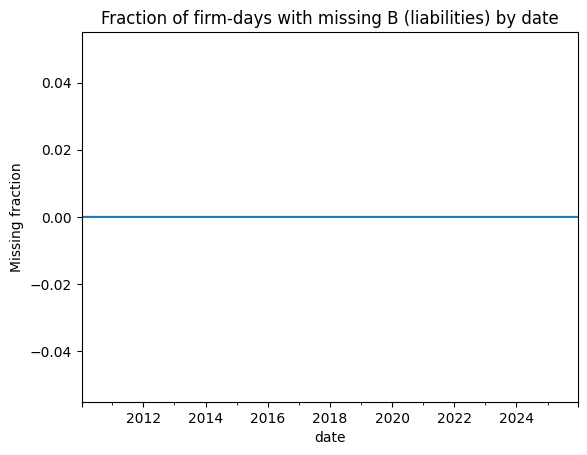

In [9]:
from matplotlib import pyplot as plt
B_miss_by_date = merton_inputs["B"].isna().groupby(merton_inputs["date"]).mean()

print(B_miss_by_date.head(10))
print(B_miss_by_date.tail(10))

B_miss_by_date.plot()
plt.title("Fraction of firm-days with missing B (liabilities) by date")
plt.ylabel("Missing fraction")
plt.show()

In [8]:
df_merton = prepare_merton_inputs(ret_daily, bs, df_rf)
df_nig_panel, nig_em_data = prepare_nig_inputs(ret_daily, bs, df_rf)

print("Merton panel shape:", df_merton.shape)
print("NIG panel shape:", df_nig_panel.shape)
print("-"*40)
print(df_merton.head())
print("-"*40)
print(df_nig_panel.head())

Merton panel shape: (190064, 11)
NIG panel shape: (190064, 8)
----------------------------------------
    gvkey       date             E  logret_mcap          isin  \
0  100022 2010-01-05  1.945046e+10     0.008080  DE0005190003   
1  100022 2010-01-06  1.975146e+10     0.015357  DE0005190003   
2  100022 2010-01-07  1.992604e+10     0.008800  DE0005190003   
3  100022 2010-01-08  1.965815e+10    -0.013535  DE0005190003   
4  100022 2010-01-11  1.936619e+10    -0.014964  DE0005190003   

                        company country_iso         r             B  \
0  BAYERISCHE MOTOREN WERKE AKT         DEU  0.007934  8.576700e+10   
1  BAYERISCHE MOTOREN WERKE AKT         DEU  0.007782  8.576700e+10   
2  BAYERISCHE MOTOREN WERKE AKT         DEU  0.007491  8.576700e+10   
3  BAYERISCHE MOTOREN WERKE AKT         DEU  0.007417  8.576700e+10   
4  BAYERISCHE MOTOREN WERKE AKT         DEU  0.007056  8.576700e+10   

   sigma_E_daily  sigma_E  
0            NaN      NaN  
1            NaN      N